<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'DataPreprocessing.ipynb',
 'Heatmap_each.ipynb']

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim


import warnings
warnings.filterwarnings('ignore')


In [3]:
from utils.hourglass import *
from utils.dataloader import *

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 4 # how deep the regression tree is 
num_tree = 3 # number of regression trees

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

# 2. Data Loader

In [ ]:
helen_trainset = Helen_set(dataset_type="train")

KeyboardInterrupt: ignored

In [ ]:
helen_testset = Helen_set(dataset_type="test")

In [ ]:
train_dataloder = DataLoader(helen_trainset, batch_size=30)
test_dataloder = DataLoader(helen_testset, batch_size=30)

# 3. Pre Train

In [ ]:
helen_sampleset = Helen_set(dataset_type="sample")
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......


In [ ]:
critical = torch.nn.MSELoss()

nIters = 200
HGNet = HGNet().to(device)
optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

Iter [1/200] loss 0.4851
Iter [10/200] loss 0.3919
Iter [20/200] loss 0.3299
Iter [30/200] loss 0.2775
Iter [40/200] loss 0.2264
Iter [50/200] loss 0.1907
Iter [60/200] loss 0.1593
Iter [70/200] loss 0.1372
Iter [80/200] loss 0.1207
Iter [90/200] loss 0.1067
Iter [100/200] loss 0.0961
Iter [110/200] loss 0.0875
Iter [120/200] loss 0.0809
Iter [130/200] loss 0.0753
Iter [140/200] loss 0.0708
Iter [150/200] loss 0.0667
Iter [160/200] loss 0.0625
Iter [170/200] loss 0.0536
Iter [180/200] loss 0.0481
Iter [190/200] loss 0.0452
Iter [200/200] loss 0.0411


Text(0.5, 1.0, 'Training Loss')

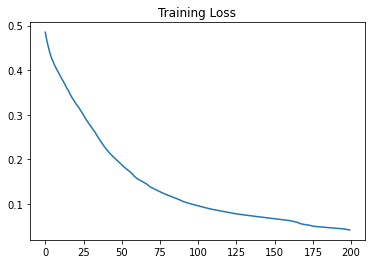

In [ ]:
loss_hist = torch.zeros(nIters)
loss_epoch = torch.zeros(10)

for iter in range(nIters):
  for i, (x,_,y) in enumerate(sample_dataloder):
    x = Variable(x,requires_grad=True).float().to(device)
    y = Variable(y).float().to(device)
    y_pred = HGNet.forward(x)
    loss = critical(y_pred, y)
    loss_epoch[i] = loss.item()

    if i == 9:
      loss_avg = torch.sum(loss_epoch)/10
      loss_hist[iter] = loss_avg
      if (iter+1)%10 == 0 or iter == 0:
        print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
plt.title("Training Loss")

In [ ]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Functions

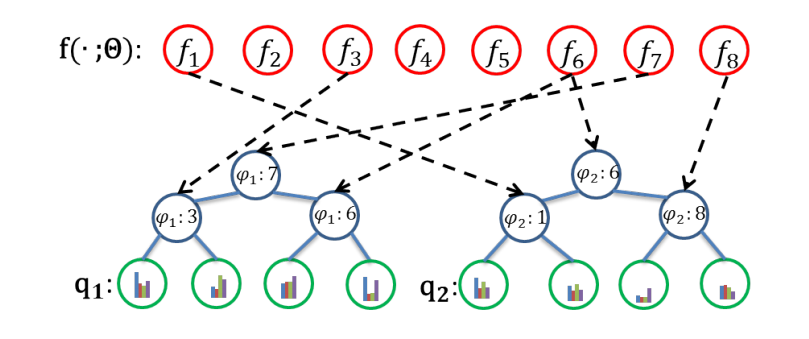

In [5]:
def split_tree(up,here,which=0):
  if up == 0:
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [44]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point

In [52]:
leaf_direction(dim_tree-1)

tensor([[0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 1.],
        [1., 0., 0.],
        [1., 0., 1.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [54]:
num_leaf_nodes

24

In [16]:
def phi(cnn_fc):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,num_leaf_nodes).to(device)
  sigm = torch.sigmoid(cnn_fc)

  direction = leaf_direction(dim_tree-1)

  for ind_tree in range(num_tree):
    
  return out

1

In [5]:
def phi(cnn_fc):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,num_leaf_nodes).to(device)
  sigm = torch.sigmoid(cnn_fc)

  out[:,0] = sigm[:,2]*sigm[:,6]
  out[:,1] = (1-sigm[:,2])*sigm[:,6]
  out[:,2] = sigm[:,5]*(1-sigm[:,6])
  out[:,3] = (1-sigm[:,5])*(1-sigm[:,6])
  out[:,4] = sigm[:,0]*sigm[:,5]
  out[:,5] = (1-sigm[:,0])*sigm[:,5]
  out[:,6] = sigm[:,7]*(1-sigm[:,5])
  out[:,7] = (1-sigm[:,7])*(1-sigm[:,5])

  return out

In [6]:
def find_coord(prob_map):
  # prob_map(200,68*256*256)

  N = prob_map.shape[0]
  P = 12
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

## 4.2 Sample Set

In [7]:
helen_sampleset = Helen_set(dataset_type="sample")
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)
helen_sampletest = Helen_set(dataset_type="sample_test")
sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......
Loading [1/30] pictures......


## 4.3 Network

In [8]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

<All keys matched successfully>

In [9]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

## 4.4 Training

In [10]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 10

criterion = torch.nn.MSELoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [11]:
for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)

  
  #####################################
  ### Train Hourglass
  ### eyes: [36:48]
  #####################################
  if round == 0:
    leaf_q = torch.ones(8,12*256*256).to(device)/(256*256)

  for iter in range(nIters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      loss = criterion(torch.matmul(cnn_prob,leaf_q), y[:,36:48,:,:].reshape(B,-1))

      loss_epoch += loss.item()
      if (iter+1)%5 == 0 or iter == 0:
        if i == 9:
          print('     CNN training, Iter [%d/%d] loss %.8f' %(iter+1, nIters, loss_epoch*1e-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


  #####################################
  ### Train Regression Trees
  #####################################
  with torch.no_grad():
    leaf_q_new = torch.zeros(8,12*256*256).to(device)/(256*256)
    loss0 = 0

    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

      leaf_q_new += torch.matmul(torch.linalg.pinv(cnn_prob), y_expand) #(8,12*256*256)

    leaf_q = leaf_q_new/10  # average among each bach
    leaf_q = torch.abs(leaf_q.reshape(8,12,-1)) #(B,12,256*256)
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    for nleaf in range(8):
      for npoints in range(12):
        leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    leaf_q = leaf_q.reshape(8,-1)

    print("     RF training, coordinate loss: %.4f" %(loss0/10))



###########################################################
Round 1, Using GPU
     CNN training, Iter [1/10] loss 0.00004793
     CNN training, Iter [5/10] loss 0.00004793
     CNN training, Iter [10/10] loss 0.00004793
     RF training, coordinate loss: 44428.8828
###########################################################
Round 2, Using GPU
     CNN training, Iter [1/10] loss 0.00004786
     CNN training, Iter [5/10] loss 0.00004786
     CNN training, Iter [10/10] loss 0.00004786
     RF training, coordinate loss: 7499.1221
###########################################################
Round 3, Using GPU
     CNN training, Iter [1/10] loss 0.00004781
     CNN training, Iter [5/10] loss 0.00004781
     CNN training, Iter [10/10] loss 0.00004781
     RF training, coordinate loss: 8316.7959
###########################################################
Round 4, Using GPU
     CNN training, Iter [1/10] loss 0.00004786
     CNN training, Iter [5/10] loss 0.00004786
     CNN training, Iter [10/

In [12]:
outputs[0:10,:]

tensor([[ 3.8680e-01,  5.9858e-02,  7.8392e-02,  8.2889e-02, -3.8358e-02,
         -1.4013e-03,  3.7878e-02, -4.3551e-01],
        [ 1.1187e-01,  2.9957e-01, -1.7830e-04,  9.1690e-02, -2.5097e-01,
          3.4739e-02, -1.6389e-01,  1.2387e-01],
        [ 3.4504e-01,  1.2036e-01, -1.4297e-01,  6.7451e-01, -1.1201e-01,
          2.5147e-01,  1.4956e-01,  3.0756e-01],
        [ 4.7719e-01,  2.7545e-01,  1.2087e-01,  2.8536e-01, -5.5719e-01,
         -3.2552e-02, -7.7560e-02, -1.3973e-01],
        [ 9.4602e-01,  3.5212e-01, -5.0468e-02, -5.6288e-02, -3.5267e-01,
          5.5570e-01, -1.7326e-02, -8.1168e-01],
        [ 6.9597e-04,  3.1884e-01,  1.4920e-01,  6.0109e-02, -9.2152e-02,
         -1.5993e-01, -1.6553e-01, -1.5579e-01],
        [ 4.0189e-01,  2.2308e-01, -1.9708e-01, -3.6790e-02, -3.6712e-01,
          7.0757e-02,  3.7308e-01,  1.9584e-01],
        [ 3.0890e-01,  3.4625e-01,  2.6239e-01,  1.0449e-01, -5.2608e-01,
          3.4412e-01,  2.5093e-02, -2.0941e-02],
        [ 3.4421

In [13]:
cnn_prob[0:10,:]

tensor([[0.2647, 0.2448, 0.2451, 0.2454, 0.2975, 0.2021, 0.1965, 0.3038],
        [0.2295, 0.2296, 0.2751, 0.2657, 0.2686, 0.2401, 0.2609, 0.2305],
        [0.2495, 0.2878, 0.2603, 0.2024, 0.3293, 0.2332, 0.2521, 0.1854],
        [0.2548, 0.2258, 0.2555, 0.2639, 0.3035, 0.1883, 0.2363, 0.2718],
        [0.2416, 0.2541, 0.3205, 0.1839, 0.4577, 0.1777, 0.1121, 0.2524],
        [0.2464, 0.2123, 0.2490, 0.2922, 0.2301, 0.2300, 0.2490, 0.2909],
        [0.2670, 0.3252, 0.2111, 0.1967, 0.3102, 0.2075, 0.2647, 0.2176],
        [0.2862, 0.2201, 0.2889, 0.2048, 0.3374, 0.2478, 0.2052, 0.2096],
        [0.2452, 0.2911, 0.2292, 0.2346, 0.2892, 0.2050, 0.2484, 0.2574],
        [0.2462, 0.2532, 0.2925, 0.2082, 0.3208, 0.2635, 0.2128, 0.2030]],
       device='cuda:0')

In [ ]:
# torch.save(Tune_HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Tune_HGNet.pt")
# torch.save(leaf_q, "/content/drive/My Drive/Face Alignment DRF/trained_models/leaf_q.pt")

## 4.5 Test

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(16,16,16)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,8,8)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*8*8,64),
                    nn.Linear(64,8),
                    nn.ReLU(inplace=True)).to(device)

Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Tune_HGNet.pt"))
leaf_q = torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/leaf_q.pt")

In [ ]:
import torchsummary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
torchsummary.summary(Tune_HGNet, (3,256,256))
print('parameters_count:',count_parameters(Tune_HGNet))

In [14]:
heatmap_loss, coord_loss = 0, 0
Tune_HGNet.eval()
criterion = torch.nn.MSELoss()

for i, (img,coord,hm) in enumerate(sample_test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  pred_heatmaps = torch.matmul(phi(outputs),leaf_q) #(15,12*256*256)
  pred_coords = find_coord(pred_heatmaps) #(15,12*2)

  heatmap_loss += criterion(pred_heatmaps, hm[:,36:48,:,:].reshape(B,-1))
  coord_loss += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))

print("Heatmap loss %.8f, Coord loss %.4f" %(heatmap_loss/10, coord_loss/10))

Heatmap loss 0.00001442, Coord loss 1267.6821


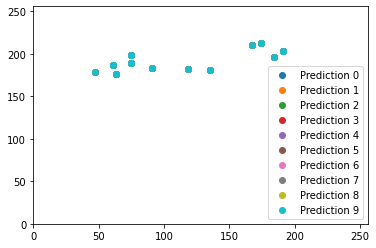

In [22]:
for ith in range(10):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction %d" %ith)

  plt.legend(loc='lower right')
  plt.xlim(0,256)
  plt.ylim(0,256)

(0.0, 256.0)

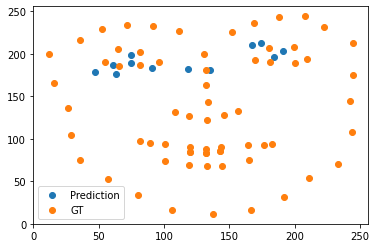

In [16]:
ith = 0

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,:,0].detach().cpu()
y2 = coord[ith,:,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

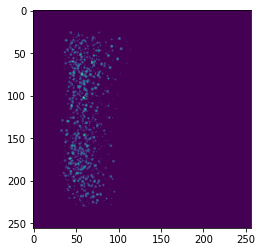

In [17]:
plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
plot_heatmaps = torch.sum(plot_heatmaps,axis=1)
plt.imshow(plot_heatmaps[ith,:,:])

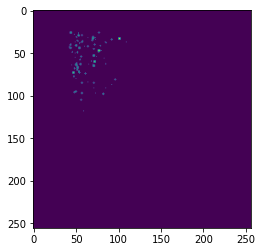

In [18]:
plt.imshow(leaf_q.reshape(8,12,256,256)[0,0,:,:].detach().cpu())

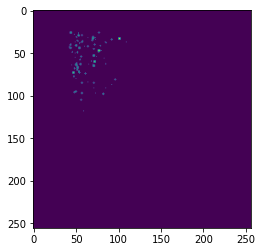

In [19]:
plt.imshow(leaf_q.reshape(8,12,256,256)[1,0,:,:].detach().cpu())

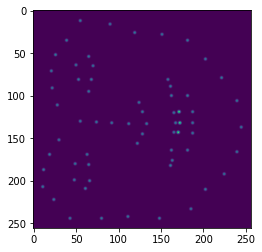

In [20]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

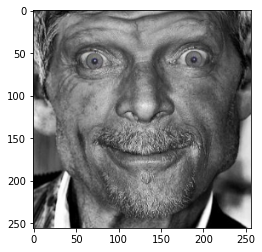

In [21]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())

# 3. Heatmap Regression

In [ ]:
#######################
# Initialization
Total_train = 10

# CNN initilization
heatmap_train_label = train_heatmap.reshape(train_size,68,-1)
heatmap_train_label = heatmap_train_label/torch.sum(heatmap_train_label,axis=2,keepdims=True)

learning_rate = 3e-4
criterion = nn.MSELoss()

num_epochs = 200
heatmap_cnn = CNN_module().to(device)
optimizer = torch.optim.Adam(heatmap_cnn.parameters(),lr=learning_rate)

In [ ]:
cnn_loss_hist = torch.zeros(num_epochs)
for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  

  # Train Regression Trees
  if round == 0:
    leaf_q = torch.ones(8,12*224*224).to(device)/(224*224)
    cnn_prob = torch.ones(train_size,8).to(device)/8
  

  with torch.no_grad():
    pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
    loss0 = torch.sum(torch.abs(pred_coord0-train_label[:,72:96]))

    htrain_reshape = heatmap_train_label[:,36:48,:].reshape(train_size,-1) #(200,68*224*224)
    leaf_q = torch.matmul(torch.linalg.pinv(cnn_prob), htrain_reshape) #(8,68*224*224)

    pred_coord1 = find_coord(torch.matmul(cnn_prob,leaf_q))
    loss1 = torch.sum(torch.abs(pred_coord1-train_label[:,72:96]))
    print("     RF training, coordinate loss: %.4f -> %.4f" %(loss0, loss1))


  # Train CNN
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = heatmap_cnn(train_tensor) #(200,8)
    cnn_prob = phi(outputs)
  
    # Points predicted by CNN
    loss = criterion(torch.matmul(cnn_prob,leaf_q), heatmap_train_label[:,36:48,:].reshape(200,-1))
    cnn_loss_hist[epoch] = loss.item()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 50 == 0 or epoch == 0:
      print('    CNN: Epoch [%d/%d], Heatmap Loss: %.8f' %(epoch+1, num_epochs, loss.item()*train_size))
  

## How to update, cross-entropy vs L1

In [ ]:
def loss_l1(q, p, l):
  return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

In [ ]:
def loss_ce(q, p, l):
  pred = torch.abs(torch.matmul(p,q))
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  return -torch.sum(l*torch.log(pred))/l.shape[0]

In [ ]:
def update_pinv(q, p, l):
  newq = torch.matmul(torch.linalg.pinv(p),l)
  newq = newq/torch.sum(newq,axis=1,keepdims=True)
  return newq

In [ ]:
def update_iter(q, p, l):
  new_q = torch.zeros(q.shape).to(q.device)

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (3,2,5)
  gamma = gamma/torch.sum(gamma,axis=2,keepdims=True)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0) # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [ ]:
l = torch.tensor([[0, 0.3, 0.5, 0.2, 0],
          [0.5, 0.3, 0.2, 0, 0],
          [0, 0, 0.2, 0.3, 0.5]])

p = torch.tensor([[0.0608, 0.9392],
        [0.6785, 0.3215],
        [0.1699, 0.8301]])

q = torch.ones(2,5)/5
qf = torch.zeros(2,5)
qf[:,2]=1

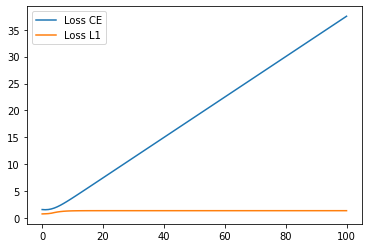

In [ ]:
Iter = 100
Loss_ce = torch.zeros(Iter+1)
Loss_l1 = torch.zeros(Iter+1)
Loss_ce[0] = loss_ce(q,p,l)
Loss_l1[0] = loss_l1(q,p,l)

for i in range(Iter):
  q = update_iter(q,p,l)
  Loss_ce[i+1] = loss_ce(q,p,l)
  Loss_l1[i+1] = loss_l1(q,p,l)

plt.plot(torch.arange(Iter+1),Loss_ce,label="Loss CE")
plt.plot(torch.arange(Iter+1),Loss_l1,label='Loss L1')
plt.legend()

In [ ]:
q0 = torch.matmul(torch.linalg.pinv(p),l)
q0 = q0/torch.sum(q0,axis=1,keepdims=True)

In [ ]:
q0

tensor([[ 0.7685,  0.3281,  0.0670, -0.1168, -0.0468],
        [-0.0950,  0.1443,  0.4013,  0.2899,  0.2595]])

In [ ]:
torch.matmul(p,q0)

tensor([[-0.0425,  0.1555,  0.3810,  0.2652,  0.2409],
        [ 0.4909,  0.2690,  0.1745,  0.0140,  0.0517],
        [ 0.0517,  0.1755,  0.3445,  0.2208,  0.2075]])

In [ ]:
loss_ce(q0,p,l)

tensor(1.3132)

In [ ]:
loss_l1(q0,p,l)

tensor(0.4956)

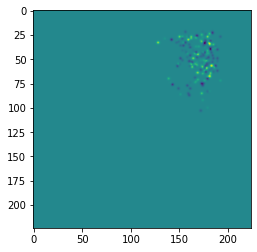

In [ ]:
plt.imshow(req[0,0,:,:])

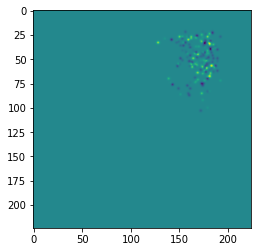

In [ ]:
plt.imshow(req[1,0,:,:])

In [ ]:
pred_heatmap = torch.matmul(cnn_prob,leaf_q) # (200,12*224*224)
pred_coord = find_coord(pred_heatmap)
pred_heatmap = pred_heatmap.reshape(200,12,224,224)*40
pred_heatmap[pred_heatmap<0.1]=0

In [ ]:
for i in range(200):
  print(torch.max(pred_heatmap[i,:,:,:]))

Text(0.5, 1.0, 'Coordinates')

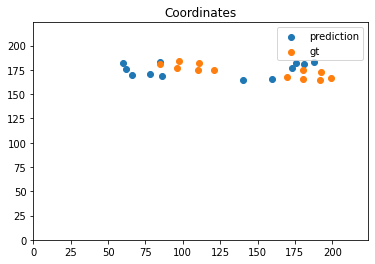

In [ ]:
nimg = 0
x = pred_coord[nimg,::2].cpu()
y = pred_coord[nimg,1::2].cpu()
plt.scatter(x,y,label="prediction")

x2 = train_label[nimg,72:96:2].cpu()
y2 = train_label[nimg,73:96:2].cpu()
plt.scatter(x2,y2,label="gt")

plt.legend()
plt.xlim(0,224)
plt.ylim(0,224)

plt.title("Coordinates")

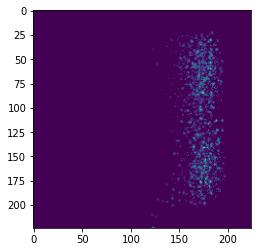

In [ ]:
nimg = 0
# predicted heatmap
plt.imshow(torch.sum(pred_heatmap[nimg,:,:,:],axis=0).cpu().detach().numpy())

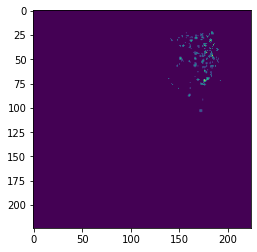

In [ ]:
plt.imshow(pred_heatmap[nimg,0,:,:].cpu().detach().numpy())

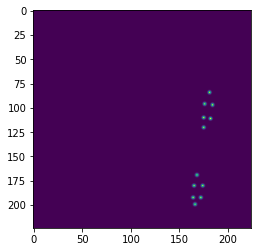

In [ ]:
# gt heatmap
plt.imshow(torch.sum(train_heatmap[nimg,36:48,:,:],axis=0).cpu())